# Graph Neural Networks versus Simulated Annealing for Maximum Independent Set

#### Author: Ivan Carvalho (@IvanIsCoding)

<a href="https://colab.research.google.com/github/IvanIsCoding/GNN-for-Combinatorial-Optimization/blob/main/02_GNN_vs_SA_for_MIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://arxiv.org/abs/2206.13211

In [ ]:
!pip install -q git+https://github.com/IvanIsCoding/GNN-for-Combinatorial-Optimization.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 KB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 66.1 MB/s eta 0

In [ ]:
from gnn_for_co.train import inner_solve_with_gnn, solve_with_annealing

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

sns.set_theme()

In [ ]:
def solve_with_gnn_mis(
    G,
    embedding_size,
    hidden_size,
    learning_rate,
    epochs,
    epochs_guess,
    dropout_rate,
    seed=2023,
    verbose=False,
    shots=5,
    is_max_cut=True,
):
    lower_bound = -G.number_of_nodes() / 10.0

    for k in range(shots):
        solution = inner_solve_with_gnn(
            G,
            embedding_size,
            hidden_size,
            learning_rate,
            epochs_guess,
            dropout_rate,
            seed + (k + 1) ** 3,
            verbose,
            is_max_cut,
        )

        if solution["energy"] <= -1:
            solution = inner_solve_with_gnn(
                G,
                embedding_size,
                hidden_size,
                learning_rate,
                epochs,
                dropout_rate,
                seed + (k + 1) ** 3,
                verbose,
                is_max_cut,
            )
            break

    return solution

In [ ]:
d3_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=3, n=i, seed=2023)) for i in range(100, 1100, 100)
}

In [ ]:
df = pd.DataFrame(columns=['N', 'MIS size', 'Algorithm'])
gnn_results = []
sa_results = []

In [ ]:
for i, G in tqdm(d3_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000, is_max_cut=False)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 25000
  epochs_guess = 100
  dropout_rate = 0.05
  gnn_sol = solve_with_gnn_mis(
        G,
        embedding_d0,
        embedding_d1,
        learning_rate,
        epochs,
        epochs_guess,
        dropout_rate,
        seed=2023,
        verbose=False,
        is_max_cut=False,
        shots=500,
    )


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

N = 100, Anneling found 44.0
N = 100, Graph Neural Networks found 37.0
N = 200, Anneling found 89.0
N = 200, Graph Neural Networks found 78.0
N = 300, Anneling found 133.0
N = 300, Graph Neural Networks found 114.0
N = 400, Anneling found 177.0
N = 400, Graph Neural Networks found 144.0
N = 500, Anneling found 221.0
N = 500, Graph Neural Networks found 183.0
N = 600, Anneling found 266.0
N = 600, Graph Neural Networks found 235.0
N = 700, Anneling found 309.0
N = 700, Graph Neural Networks found 269.0
N = 800, Anneling found 352.0
N = 800, Graph Neural Networks found 300.0
N = 900, Anneling found 396.0
N = 900, Graph Neural Networks found 334.0
N = 1000, Anneling found 440.0
N = 1000, Graph Neural Networks found 384.0


In [ ]:
for n, cut_size in zip(range(100, 1100, 100), gnn_results):
  df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [ ]:
for n, cut_size in zip(range(100, 1100, 100), sa_results):
  df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

[]

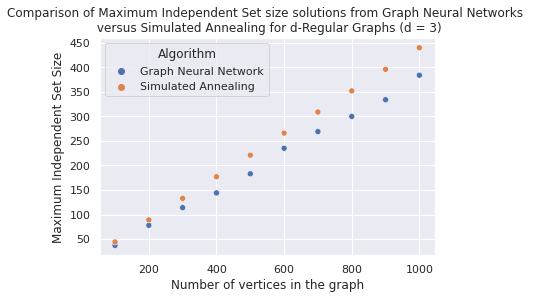

In [ ]:
sns.scatterplot(
    data=df, x ="N", y="MIS size", hue="Algorithm"
).set(
    title="Comparison of Maximum Independent Set size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 3)",
    ylabel="Maximum Independent Set Size",
    xlabel="Number of vertices in the graph",
)
plt.plot()

In [ ]:
d5_graphs = {
    i: nx.convert_node_labels_to_integers(nx.random_regular_graph(d=5, n=i, seed=2023)) for i in range(100, 1100, 100)
}

In [ ]:
df = pd.DataFrame(columns=['N', 'MIS size', 'Algorithm'])
gnn_results = []
sa_results = []

In [ ]:
for i, G in tqdm(d5_graphs.items()):
  
  annealing_sol = solve_with_annealing(G, num_reads=2000, is_max_cut=False)
  model = annealing_sol["model"]
  sa_results.append(-annealing_sol["energy"])

  print(f"N = {i}, Anneling found {sa_results[-1]}")

  embedding_d0 = int(np.sqrt(i))
  embedding_d1 = embedding_d0//2
  learning_rate = 0.005
  epochs = 25000
  epochs_guess = 100
  dropout_rate = 0.05
  gnn_sol = solve_with_gnn_mis(
        G,
        embedding_d0,
        embedding_d1,
        learning_rate,
        epochs,
        epochs_guess,
        dropout_rate,
        seed=2023,
        verbose=False,
        is_max_cut=False,
        shots=500,
    )


  gnn_results.append(
      -model.decode_sample(gnn_sol["solution"], vartype="BINARY").energy
  )
  print(f"N = {i}, Graph Neural Networks found {gnn_results[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

N = 100, Anneling found 36.0
N = 100, Graph Neural Networks found 30.0
N = 200, Anneling found 74.0
N = 200, Graph Neural Networks found 58.0
N = 300, Anneling found 113.0
N = 300, Graph Neural Networks found 89.0
N = 400, Anneling found 149.0
N = 400, Graph Neural Networks found -0.0
N = 500, Anneling found 186.0
N = 500, Graph Neural Networks found 153.0
N = 600, Anneling found 223.0
N = 600, Graph Neural Networks found 189.0
N = 700, Anneling found 260.0
N = 700, Graph Neural Networks found 218.0
N = 800, Anneling found 298.0
N = 800, Graph Neural Networks found -0.0
N = 900, Anneling found 333.0
N = 900, Graph Neural Networks found 274.0
N = 1000, Anneling found 368.0
N = 1000, Graph Neural Networks found 308.0


In [ ]:
for n, cut_size in zip(range(100, 1100, 100), gnn_results):
  df.loc[len(df)] = [n, cut_size, "Graph Neural Network"]

In [ ]:
for n, cut_size in zip(range(100, 1100, 100), sa_results):
  df.loc[len(df)] = [n, cut_size, "Simulated Annealing"]

[]

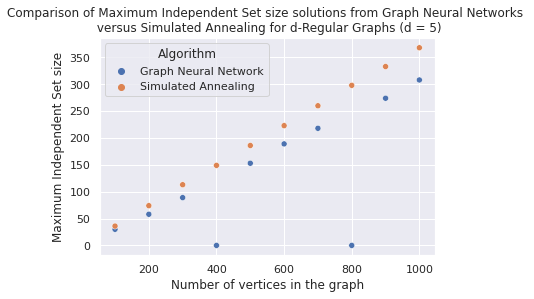

In [ ]:
sns.scatterplot(
    data=df, x ="N", y="MIS size", hue="Algorithm"
).set(
    title="Comparison of Maximum Independent Set size solutions from Graph Neural Networks \n versus Simulated Annealing for d-Regular Graphs (d = 5)",
    ylabel="Maximum Independent Set size",
    xlabel="Number of vertices in the graph",
)
plt.plot()